In [80]:
from fuzzywuzzy import fuzz

import os
import sys

import pandas as pd
pd.options.display.max_columns = 999
import sqlalchemy as sqla
from sqlalchemy import create_engine
%matplotlib inline  

DB_URI = os.getenv('CD_DWH')
engine = create_engine(DB_URI)

In [81]:
# Load data

QUERY = """
select
   distinct( candidate_name) as dbname
from data_ingest.casos__california_candidate_statewide_election_results

union

select
   distinct( recipient_candidate_name)
from trg_analytics.candidate_contributions
"""
with engine.begin() as conn:
    sql_results = pd.read_sql(QUERY, conn)

#sql_results = sql_results.dropna()
print("Size:", len(sql_results))
sql_results.head(5)

Size: 2574


,dbname
0,None
1,"KNIGHT, WILLIAM J. \PETE\"""""
2,Adam Shbeita
3,"HILL, JERRY A."
4,"ACOSTA, GEORGIA L."


In [82]:
# Perform matching

import re
regex = re.compile(r'[^a-z ]')
def clean(name):
    mi = []
    sr = []
    jr = []
    ii = []
    iii = []
    
    # Handle comma
    parts = name.split(",")
    if len(parts) == 2: # If they aren't equal we have more or less than 1 comma, which we don't know how to handle. eg not "Smith, John M"
        name = parts[1].strip() + " " + parts[0].strip()
    
    # Handle symboles
    name = regex.sub("", name.lower()) # lower and remove none a-z characters
    
    # Handle sr jr ii iii to front of the name and middle initial to the end
    parts = name.split(" ")
    i = len(parts)
    while i > 0: 
        i -= 1
        if len(parts[i]) == 1: ## Middle Initial
            mi += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "sr":
            sr += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "jr":
            jr += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "ii":
            ii += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "iii":
            iii += [parts[i]]
            del parts[i]
            continue
            
    # Handle mc lastname -> mclastname
    if len(parts) > 1 and parts[-2] == "mc":
        if not parts[-1].startswith("mc"):
            parts[-1] = "mc" + parts[-1]
            del parts[-2]
    
    name = " ".join(sr + jr + ii + iii + parts + mi)

    return name

# Take in a cleaned name and pull out the last name
# Easier said than done if you've looked at the data. "SIMON JR., WILLIAM E." "MONVILLE III, LOUIS G." "BACA. JR., JOE" "BACA JR. JR., JOE" and more
# So I'm thinking:
#  take in a clean'd name
#  start at the last token, 
#  take steps towards the front every time its a ["jr", "sr"] or ["ii", "iii"] or len(part[i]) == 1 (assuming its an initial)
#  now we should be at the last name
#  if the word before this word is mc, prepend mc to this word (my tests have shown we don't also need to test that this word does not already begin with mc, but its a simple code to guard against)
#  return lastname
not_last_names = ["jr", "sr", "ii", "iii"]
def lastname(name):
    parts = name.split(" ")
    i = len(parts) - 1
    while len(parts[i]) == 1 or parts[i] in not_last_names:
        i -= 1
    if parts[i - 1] == "mc":
        if not parts[i].startswith("mc"):
            parts[i] = "mc" + parts[i]
    return parts[i]

# Take in 2 names, return 1 number, percent, 0-100, int
def fuzz_ratio(name1, name2):
    name1 = clean(name1)
    name2 = clean(name2)
    whole_name_match_ratio = fuzz.ratio(name1, name2) / 100
    last_name_match_ratio = fuzz.ratio(lastname(name1), lastname(name1)) / 100
    return int(whole_name_match_ratio * last_name_match_ratio * 100)

# Take in 2 names, return 1 number, percent, 0-100, int
def fuzz_partial_ratio(name1, name2):
    name1 = clean(name1)
    name2 = clean(name2)
    whole_name_match_ratio = fuzz.partial_ratio(name1, name2) / 100
    last_name_match_ratio = fuzz.partial_ratio(lastname(name1), lastname(name1)) / 100
    return int(whole_name_match_ratio * last_name_match_ratio * 100)
    
# Take in 2 names, return 1 number, percent, 0-100, int
def fuzzymatch(name1, name2):
    return fuzz_ratio(name1, name2)


def fuzzy_match(sql_names, fuzzy_match_fun = fuzzymatch, match_threshold = 85):
    
    import time
    time_start = time.time()

    UPPER_LIMIT = match_threshold # Anything >= this score will be considered "a definite match"
    LOWER_LIMIT = match_threshold # Anything <= this score will be considered "a definite miss"

    db_dbname_2_id = pd.DataFrame(columns=["dbname", "id"])  # [] # (dbname, id)
    db_id_2_showname = pd.DataFrame(columns=["id", "showname"]) # [] # (id, showname)

    # Static insert for "None" as -1 
    # db_dbname_2_id = db_dbname_2_id.append({"dbname" : "None", "id" : -1}, ignore_index=True)
    # db_id_2_showname = db_id_2_showname.append({"id" : -1, "showname" : "None"}, ignore_index=True)

    next_id = 1 # At some point this should be set equal to "retreive last id in db"
    total = len(sql_names)
    count_times = 0

    hits = []
    misses = []
    skips = []
    news = []
    nones = []

    for index, input_dbname in sql_names.iterrows():
        count_times += 1
        print(str(count_times) + " " + str(count_times / total * 100) + "%" + " "*10, end="\r") 
        # \r causes it to print over itself, so instead of being spammed with text, its a nice little ticker

        dbname = input_dbname.dbname

        if dbname is None:
            nones += [index]
            continue

        if sum(db_dbname_2_id["dbname"] == dbname) > 0: # If the name is already processed
            skips += [str(count_times) + " Skip: " + str(dbname)]
            continue # Skip it

        fuzzymatches = []
        for index, row in db_dbname_2_id.iterrows(): # iterrows is really slow I think?
            name = row["dbname"]
            id_ = row["id"] 
            fuzzymatches += [[fuzzy_match_fun(name, dbname), id_, name]]

        if not fuzzymatches:
            news += [str(count_times) + " New: " + str(dbname)]
            db_dbname_2_id = db_dbname_2_id.append({"dbname" : dbname, "id" : next_id}, ignore_index=True)
            db_id_2_showname = db_id_2_showname.append({"id" : next_id, "showname" : dbname}, ignore_index=True)
            next_id += 1
            continue # NEXT!

        fuzzymatches.sort(reverse=True, key=lambda x: x[0])
        h_match_name = fuzzymatches[0][2]
        h_match_id = fuzzymatches[0][1]
        h_match_score = fuzzymatches[0][0]

        if h_match_score >= UPPER_LIMIT:
            db_dbname_2_id = db_dbname_2_id.append({"dbname" : dbname, "id" : h_match_id}, ignore_index=True)   
            hits += [str(h_match_score) + "% " + str(count_times) + " Match: " + str(dbname) + " vs " + str(h_match_name)]

        elif h_match_score <= LOWER_LIMIT:
            db_dbname_2_id = db_dbname_2_id.append({"dbname" : dbname, "id" : next_id}, ignore_index=True)
            db_id_2_showname = db_id_2_showname.append({"id" : next_id, "showname" : dbname}, ignore_index=True)
            next_id += 1
            misses += [str(h_match_score) + "% " + str(count_times) + " Miss: " + str(dbname) + " vs " + str(h_match_name)]

        else:
            print(h_match_score, "% match: ", dbname, " vs ", name, " ")
            print("Same person (y/N)? ")
            answer = input()
            if answer == "":
                answer = "n"

            if answer.lower() == "y":
                db_dbname_2_id = db_dbname_2_id.append({"dbname" : dbname, "id" : h_match_id}, ignore_index=True)
            elif answer.lower() == "n":
                db_dbname_2_id = db_dbname_2_id.append({"dbname" : dbname, "id" : next_id}, ignore_index=True)
                db_id_2_showname = db_id_2_showname.append({"id" : next_id, "showname" : dbname}, ignore_index=True)
                next_id += 1

    print("DONE!" + " "*50)

    misses.sort(reverse=True, key=lambda x: int(x.split("%")[0]))
    hits.sort(reverse=True, key=lambda x: int(x.split("%")[0]))

    print("Misses:")
    print("\n".join(misses))
    print("Skips:")
    #print("\n".join(skips))
    print("New:")
    print("\n".join(news))
    print("Hits:")
    print("\n".join(hits))
    print("Nones indexes:")
    #print("\n".join(nones))

    print(db_dbname_2_id)
    print(db_id_2_showname)
    print("News:", len(news))
    print("Hits:", len(hits))
    print("Misses:", len(misses))
    print("Skips:", len(skips))
    print("Nones:", len(nones))
    print("Total:", len(hits) + len(misses) + len(skips) + len(news) + len(nones))
    print("Dataset len:", total)
    print("Result len:", len(db_dbname_2_id))

    print("Accuracy:", len(hits) / total)

    time_elapsed = time.time() - time_start
    print("Took:", time_elapsed, " seconds")
    
    return hits, misses
    
def plot_scores(hits, misses, limit = 0):
    scores = pd.DataFrame(columns=["score"])
    #scores = scores.append({"score" : score}, ignore_index=True)

    for h in hits:
        score = int(h.split("%")[0])
        scores = scores.append({"score" : score}, ignore_index=True)

    for h in misses:
        score = int(h.split("%")[0])
        scores = scores.append({"score" : score}, ignore_index=True)

    score[scores["score"] >= limit].value_counts(sort=False).plot(kind="bar", figsize=(12,5), colormap="winter")
    

#hits, misses = fuzzy_match(sql_results, fuzzymatch)
#plot_scores(hits, misses)


In [ ]:
# Save pairings
db_dbname_2_id.to_csv("./dbname_2_id___2.csv", index=False)
db_id_2_showname.to_csv("./db_id_2_showname___2.csv", index=False)
#db_dbname_2_id

In [54]:
# Load pairings
csv_data = pd.read_csv("./dbname_2_id___2.csv")
csv_data = csv_data.set_index("dbname") # Now we can do csv_data.loc[str(x)].id to get the id

# Remove any column and resave
# csv_data = csv_data.drop(csv_data.columns[[0]], 1)
# csv_data.to_csv("./dbname_2_id.csv", index=False)

# Indexing the data
# csv_data.loc[csv_data.dbname == str(None), "id" ].values[0] # Pretty slow
# csv_data.loc[str(None)].id # Much faster


def dbname_to_id(name):
    try:
        return int(csv_data.loc[str(name)].id)
    except:
        return None

csv_data.head(5)

,id
dbname,
"KNIGHT, WILLIAM J. \PETE\""""",1
Adam Shbeita,2
"HILL, JERRY A.",3
"ACOSTA, GEORGIA L.",4
"GUILLEN, ABEL",5


In [62]:
# Load data

QUERY = """
select
   *,
   candidate_name as dbname
from data_ingest.casos__california_candidate_statewide_election_results
"""
with engine.begin() as conn:
    sql_results = pd.read_sql(QUERY, conn)

#sql_results = sql_results.dropna()
print("Size:", len(sql_results))
sql_results.head(5)

Size: 7083


,election_name,county_name,contest_name,candidate_name,incumbent_flag,party_name,vote_total,dbname
0,2010 General,Alameda,governor,Jerry Brown,N,DEM,340190.0,Jerry Brown
1,2010 General,Alpine,governor,Jerry Brown,N,DEM,319.0,Jerry Brown
2,2010 General,Amador,governor,Jerry Brown,N,DEM,6750.0,Jerry Brown
3,2010 General,Butte,governor,Jerry Brown,N,DEM,32789.0,Jerry Brown
4,2010 General,Calaveras,governor,Jerry Brown,N,DEM,7737.0,Jerry Brown


In [75]:
def myint(n):
    try:
        return int(n)
    except:
        return -1
# sql_results["ID"] = None
#test = sql_results.head(10000).copy(True)
# Create an ID column where its value is the rows dbname's id from csv_data[str(dbname)]
sql_results = sql_results.loc[pd.notnull(sql_results.dbname),:] # Drop rows whos dbname is null
sql_results.loc[:, "id"] = sql_results["dbname"].apply(dbname_to_id)
#sql_results["id"] = sql_results["id"].apply(myint) # ids come out as float if there is a None or NA
sql_results
#csv_data["id"][csv_data.dbname == sql_results.dbname]
#  # GARCIA, BONNIE

,election_name,county_name,contest_name,candidate_name,incumbent_flag,party_name,vote_total,dbname,id
0,2010 General,Alameda,governor,Jerry Brown,N,DEM,340190.0,Jerry Brown,545
1,2010 General,Alpine,governor,Jerry Brown,N,DEM,319.0,Jerry Brown,545
2,2010 General,Amador,governor,Jerry Brown,N,DEM,6750.0,Jerry Brown,545
3,2010 General,Butte,governor,Jerry Brown,N,DEM,32789.0,Jerry Brown,545
4,2010 General,Calaveras,governor,Jerry Brown,N,DEM,7737.0,Jerry Brown,545
5,2010 General,Colusa,governor,Jerry Brown,N,DEM,1878.0,Jerry Brown,545
6,2010 General,Contra Costa,governor,Jerry Brown,N,DEM,211125.0,Jerry Brown,545
7,2010 General,Del Norte,governor,Jerry Brown,N,DEM,4093.0,Jerry Brown,545
8,2010 General,El Dorado,governor,Jerry Brown,N,DEM,29826.0,Jerry Brown,545
9,2010 General,Fresno,governor,Jerry Brown,N,DEM,85743.0,Jerry Brown,545


In [40]:
mc = []
mcmc = []
numerals = []
numerics = ["i", "ii", "iii", "iv"]
titales = []
titles = ["jr", "sr"] 
short = []
middle = []
middlenames = []
names = []
names4 = []
names5 = []
names1 = []

# There are "pete MC pommer" and "pete MCpommer". there are not "pete mc mcpommer". are there other things that would qualify as needing a space in the last name?9
# There are names ending with the initial. lastnames with the middle initial preceeding. "pete pommer MI" len(parts[-1]) == 1
# There are names ending in jr sr
# There are names ending with ii iii

# There are names with jr sr in the middle
# There are not names with ii iii in the middle
# There are same people with multiple 1 letter words in their names

# There are some people with last name prefixes that are not MC. example name: "name de lorance" -> "name delorance"

## maybe manually toss out any names who dont have equal sr jr ii iii. and if there is a MI on both check that too otherwise ignore MI, but then what about "pete pommer j" misses "pete pommer n" but both hit "pete pommer"?

## TODO start from end, go to front, collect all sr jr ii iii and mi (len==1) into buckets, del that parts[i] if its one of those, finally " ".join([sr + jr + ii + iii + parts])

# joe baca jr jr
# joe baca jr


not_last_names = ["jr", "sr", "ii", "iii"]
def lastname(name):
    parts = name.split(" ")
    i = len(parts) - 1
    while len(parts[i]) == 1 or parts[i] in not_last_names:
        i -= 1
    if parts[i - 1] == "mc":
        if not parts[i].startswith("mc"):
            parts[i] = "mc" + parts[i]
    return parts[i]

import re
regex = re.compile(r'[^a-z ]')
def clean(name):
    mi = []
    sr = []
    jr = []
    ii = []
    iii = []
    
    # Handle comma
    parts = name.split(",")
    if len(parts) == 2: # If they aren't equal we have more or less than 1 comma, which we don't know how to handle. eg not "Smith, John M"
        name = parts[1].strip() + " " + parts[0].strip()
    
    # Handle symboles
    name = regex.sub("", name.lower()) # lower and remove none a-z characters
    
    # Handle sr jr ii iii to front of the name and middle initial to the end
    parts = name.split(" ")
    i = len(parts)
    while i > 0: 
        i -= 1
        if len(parts[i]) == 1: ## Middle Initial
            mi += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "sr":
            sr += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "jr":
            jr += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "ii":
            ii += [parts[i]]
            del parts[i]
            continue
        if parts[i] == "iii":
            iii += [parts[i]]
            del parts[i]
            continue
            
    # Handle mc lastname -> mclastname
    if len(parts) > 1 and parts[-2] == "mc":
        if not parts[-1].startswith("mc"):
            parts[-1] = "mc" + parts[-1]
            del parts[-2]
    
    name = " ".join(sr + jr + ii + iii + parts + mi)

    return name

for name, id in csv_data.iterrows():
    num_of_1s = 0
    name = clean(name)
    parts = name.split(" ")
    names += [name]
    for p in parts:
        if len(p) == 1:
            num_of_1s += 1
    if num_of_1s > 1:
        names1 += [name]
        
    if len(parts) == 4:
        names4 += [name]
    if len(parts) == 5:
        names5 += [name]
    if len(parts) >= 2:
        if parts[-2] == "mc":
            mc += [name]
        if parts[-1].startswith("mc"):
            mc += [name]
            if parts[-2] == "mc":
                mcmc += [name]
    # if any([n == parts[-1] for n in numerics]): # Another way by Perry
    for n in numerics:
        if n == parts[-1]:
            numerals += [name]
            continue
        for p in parts:
            if p == n:
                middle += [name]
    for t in titles:
        if name.endswith(t):
            titales += [name]
            continue
        for p in parts:
            if p == t:
                middle += [name]
    if len(parts[-1]) == 1:
        short += [name]

print("MCMC:")
#print("\n".join(mcmc))    
print("MC:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in mc]))
print("\n\nNumerals:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in numerals]))
print("\n\nTitles:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in titales]))
print("\n\nShorts:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in short]))
print("\n\nMiddle:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in middle]))
print("\n\nnames in middle:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in middlenames]))
print("\n\n4 word names:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in names4]))
print("\n\n5 word names:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in names5]))
print("\n\nmore then 1 1 word names:")
print("\n".join(["{} -- {}".format(s, lastname(s)) for s in names1]))

pd.Series([len(n.split(" ")) for n in names]).value_counts()



MCMC:
MC:
john mccann -- mccann
mary catherine mcilroy -- mcilroy
kevin mccarty -- mccarty
thomas mcclintock -- mcclintock
gloria negrete mcleod -- mcleod
kevin mccarthy -- mccarthy
nellie mcgarry -- mcgarry
mike mcguire -- mcguire
kevin mccarty -- mccarty
kelly mccarty -- mccarty
kevin mccarthy -- mccarthy
rob mccoy -- mccoy
kevin mccarthy -- mccarthy
michael joseph mcgill -- mcgill
tom mcclintock -- mcclintock
michael mcgill -- mcgill
rob mccoy -- mccoy
kevin mccarthy -- mccarthy
kristine lang mcdonald -- mcdonald
gloria negrete mcleod -- mcleod
don mckinney -- mckinney
keith brandon mccowen -- mccowen
tom mcclintock -- mcclintock
evan mcmullin -- mcmullin
patricia mckeon -- mckeon
jerry mcnerney -- mcnerney
barbara mciver -- mciver
bruce mcpherson -- mcpherson
bruce david mcfarland -- mcfarland
gloria negrete mcleod -- mcleod
kevin mccarty -- mccarty
john mccann -- mccann
sr joseph mccray -- mccray
bradley mcfadden -- mcfadden
jerry mcnerney -- mcnerney
nellie mcgarry -- mcgarry
sr 

2    1702
3     816
4      55
dtype: int64

DONE!                                                  
Misses:
95% 354 Miss: STEEL, MICHELLE vs PARK STEEL, MICHELLE
95% 753 Miss: POLANCO, RICHARD vs Richard Pan*
95% 1132 Miss: Tom McClintock* vs MC CLINTOCK, THOMAS
95% 1513 Miss: David Harmer vs HARE, DAVID M.
95% 1900 Miss: AKILI, GREG vs AKILI, GREGORY
95% 1915 Miss: FONG, MICHAEL vs ENG, MICHAEL
95% 1940 Miss: SMITH, MARIANNE vs SMITH, MARIANNE BOPP
95% 2027 Miss: LEDFORD, JAMES C. vs MEDFORD, JAMES D.
95% 2170 Miss: CHAU, EDWIN vs Edwin "Ed" Chau
95% 2213 Miss: John M. W. Moorlach vs MOORLACH, JOHN
94% 514 Miss: BACA. JR., JOE vs BACA JR. JR., JOE
94% 573 Miss: PHILLIPS, STEVE vs HILL, STEVE
94% 679 Miss: Michael Havig vs DAVIS, MICHAEL
94% 734 Miss: Charlie Schaupp vs SCHAUPP, CHARLES E.
94% 967 Miss: HARRINGTON, MICHAEL vs HARRISON, MICHAEL
94% 1039 Miss: BURTON, JOHN L. vs BARTON, JOHN H.
94% 1242 Miss: WAKIM, SAMUEL vs WAKIM, SAM
94% 1264 Miss: Bob Flores vs FOSTER, BOB
94% 1281 Miss: PETTIS, GREG vs PETTIS, GREGORY S.
94% 

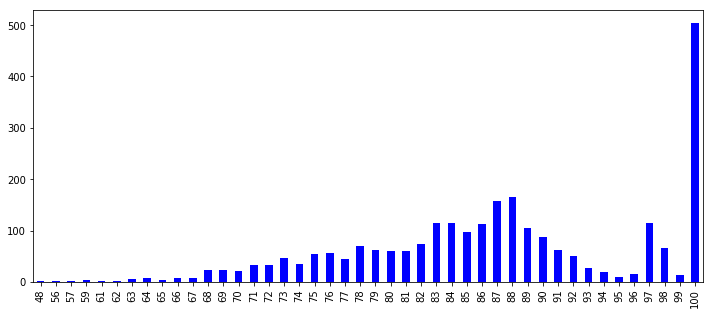

In [45]:
from pyjarowinkler import distance

def jarowinkler(name1, name2):
    name1 = clean(name1)
    name2 = clean(name2)
    whole_name_match_ratio = distance.get_jaro_distance(name1, name2)
    last_name_match_ratio = distance.get_jaro_distance(lastname(name1), lastname(name1))
    return int(whole_name_match_ratio * last_name_match_ratio * 100)
    

hits, misses = fuzzy_match(sql_results, jarowinkler, 96)
plot_scores(hits, misses)

DONE!                                                  
Misses:
84% 589 Miss: Bob Wieckowski vs WIECKOWSKI, ROBERT
84% 681 Miss: DUNN, JOE vs DUNN, JOSEPH
84% 1077 Miss: BENNETT, JAMES D. vs James (JD) Bennett
84% 1082 Miss: Michael "Mickey" Harrington vs HARRINGTON, MICHAEL
84% 1109 Miss: BERRYHILL, THOMAS C. vs BERRYHILL, TOM
84% 1534 Miss: John Paul (Jack) Lindblad vs LINDBLAD, JOHN P. (JACK)
84% 2206 Miss: Rick Ciardella vs CIARDELLA, RICHARD
84% 2240 Miss: Ian Charles Calderon vs Charles M. Calderon*
84% 2410 Miss: JAKE, JOHN vs BAKER, JOHN
84% 2492 Miss: Kevin J. Lincoln, II vs LINCOLN, KEVIN
84% 2571 Miss: STRICKLAND, PAUL vs STRICKLAND, AUDRA
83% 129 Miss: BILBREY, MICHAEL vs Michael Breyer
83% 516 Miss: SANDOVAL, GABRIEL vs SANDOVAL, GREG
83% 573 Miss: PHILLIPS, STEVE vs HILL, STEVE
83% 1035 Miss: ARAMBULA, JUAN vs Joaquin Arambula
83% 1094 Miss: PAPAN, VIRGINIA vs PAPAN, GINA
83% 1102 Miss: Curren D. Price, Jr.* vs PRICE, CURREN
83% 1177 Miss: HERTZBERG, ROBERT vs Bob Hertzbe

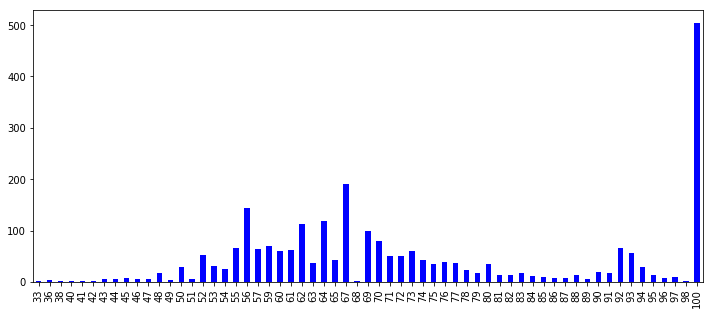

In [46]:
hits, misses = fuzzy_match(sql_results, fuzzymatch)
plot_scores(hits, misses)

In [41]:
#hits, misses = fuzzy_match(sql_results, fuzz_partial_ratio)
#plot_scores(hits, misses)

DONE!                                                  
Misses:
95% 354 Miss: STEEL, MICHELLE vs PARK STEEL, MICHELLE
95% 753 Miss: POLANCO, RICHARD vs Richard Pan*
95% 1132 Miss: Tom McClintock* vs MC CLINTOCK, THOMAS
95% 1513 Miss: David Harmer vs HARE, DAVID M.
95% 1900 Miss: AKILI, GREG vs AKILI, GREGORY
95% 1915 Miss: FONG, MICHAEL vs ENG, MICHAEL
95% 1940 Miss: SMITH, MARIANNE vs SMITH, MARIANNE BOPP
95% 2027 Miss: LEDFORD, JAMES C. vs MEDFORD, JAMES D.
95% 2170 Miss: CHAU, EDWIN vs Edwin "Ed" Chau
95% 2213 Miss: John M. W. Moorlach vs MOORLACH, JOHN
94% 514 Miss: BACA. JR., JOE vs BACA JR. JR., JOE
94% 573 Miss: PHILLIPS, STEVE vs HILL, STEVE
94% 679 Miss: Michael Havig vs DAVIS, MICHAEL
94% 734 Miss: Charlie Schaupp vs SCHAUPP, CHARLES E.
94% 967 Miss: HARRINGTON, MICHAEL vs HARRISON, MICHAEL
94% 1039 Miss: BURTON, JOHN L. vs BARTON, JOHN H.
94% 1242 Miss: WAKIM, SAMUEL vs WAKIM, SAM
94% 1264 Miss: Bob Flores vs FOSTER, BOB
94% 1281 Miss: PETTIS, GREG vs PETTIS, GREGORY S.
94% 

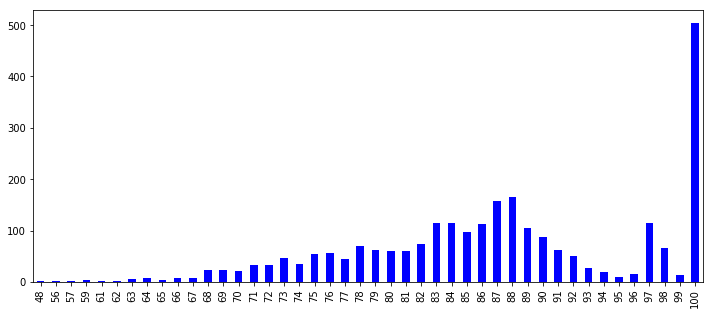

In [47]:
def jarowinkler2(name1, name2):
    name1 = clean(name1)
    name2 = clean(name2)
    whole_name_match_ratio = distance.get_jaro_distance(name1, name2)
    #last_name_match_ratio = distance.get_jaro_distance(lastname(name1), lastname(name1))
    return int(whole_name_match_ratio * 100) #last_name_match_ratio * 100)
    

hits, misses = fuzzy_match(sql_results, jarowinkler2, 96)
plot_scores(hits, misses)

DONE!                                                  
Misses:
95% 354 Miss: STEEL, MICHELLE vs PARK STEEL, MICHELLE
95% 753 Miss: POLANCO, RICHARD vs Richard Pan*
95% 1132 Miss: Tom McClintock* vs MC CLINTOCK, THOMAS
95% 1900 Miss: AKILI, GREG vs AKILI, GREGORY
95% 1915 Miss: FONG, MICHAEL vs ENG, MICHAEL
95% 1940 Miss: SMITH, MARIANNE vs SMITH, MARIANNE BOPP
95% 2170 Miss: CHAU, EDWIN vs Edwin "Ed" Chau
94% 514 Miss: BACA. JR., JOE vs BACA JR. JR., JOE
94% 573 Miss: PHILLIPS, STEVE vs HILL, STEVE
94% 679 Miss: Michael Havig vs DAVIS, MICHAEL
94% 967 Miss: HARRINGTON, MICHAEL vs HARRISON, MICHAEL
94% 1242 Miss: WAKIM, SAMUEL vs WAKIM, SAM
94% 1264 Miss: Bob Flores vs FOSTER, BOB
94% 1359 Miss: Mark Reed vs GREEN, MARK
94% 1470 Miss: DUTRA, JOHN vs TRAN, JOHN
94% 1636 Miss: ARMENTA, CHRISTOPHER vs ARELLANO, CHRISTOPHER
94% 1759 Miss: Steve Cohn vs CHOI, STEVEN
94% 1862 Miss: CENDANA TORLAKSON, MAE vs Mae Cendaña Torlakson
94% 1904 Miss: ENG, MICHAEL vs Michael Allen
94% 1979 Miss: BUC

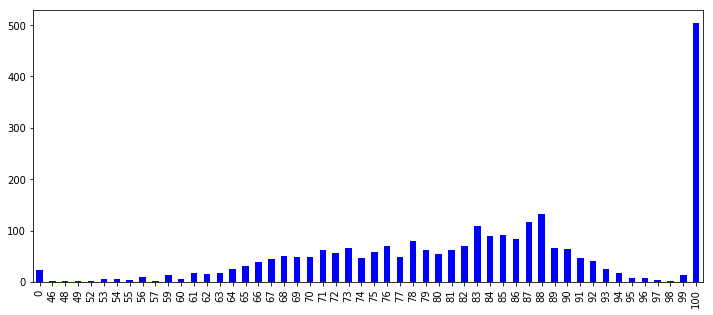

In [84]:
def mi(name):
    parts = name.split(" ")
    if len(parts[-1]) == 1:
        return parts[-1]
    else:
        return ""

def jarowinkler2(name1, name2):
    name1 = clean(name1)
    name2 = clean(name2)
    mi1 = mi(name1)
    mi2 = mi(name2)
    mi_match = -1
    if mi1 == mi2:
        mi_match = 1
    else:
        mi_match = 0.01
    whole_name_match_ratio = distance.get_jaro_distance(name1, name2)
    #last_name_match_ratio = distance.get_jaro_distance(lastname(name1), lastname(name1))
    return int(whole_name_match_ratio * mi_match * 100) #last_name_match_ratio * 100)
    

hits, misses = fuzzy_match(sql_results, jarowinkler2, 96)
plot_scores(hits, misses)

<function __main__.dbname_to_id>